# Machine Learning - Project

In [1]:
%pip install imbalanced-learn
%pip install matplotlib
%pip install pandas
%pip install scikit-learn

from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


                                              0.0/226.0 kB ? eta -:--:--
     -------------------------------------  225.3/226.0 kB 6.9 MB/s eta 0:00:01
     -------------------------------------- 226.0/226.0 kB 4.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Columns Definitions

Here is the meaning of every columns explain in `Xente_Variable_Definitions.csv`.

 * **TransactionId**: Unique transaction identifier on platform
 * **BatchId**: Unique number assigned to a batch of transactions for processing
 * **AccountId**: Unique number identifying the customer on platform
 * **SubscriptionId**: Unique number identifying the customer subscription
 * **CustomerId**: Unique identifier attached to Account
 * **CurrencyCode**: Country currency
 * **CountryCode**: Numerical geographical code of country
 * **ProviderId**: Source provider of Item bought.
 * **ProductId**: Item name being bought.
 * **ProductCategory**: ProductIds are organized into these broader product categories.
 * **ChannelId**: Identifies if customer used web,Android, IOS, pay later or checkout.
 * **Amount**: Value of the transaction. Positive for debits from customer account and negative for credit into customer account
 * **Value**: Absolute value of the amount
 * **TransactionStartTime**: Transaction start time
 * **PricingStrategy**: Category of Xente's pricing structure for merchants
 * **FraudResult**: Fraud status of transaction 1 -yes or 0-No


# Load training data

The first thing we do is to load the training data from `training.csv`.

In [2]:
training_data_path = './data/training.csv'

# Read data from file
training_data = pd.read_csv(training_data_path)

# Set the 'TransactionId' as index
training_data.set_index('TransactionId', inplace=True)

training_data.head(5)

,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
TransactionId,,,,,,,,,,,,,,,
TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


# Data analysis

Now that we have our data loaded, we will analyse the differents data in order the get the best possible model.

# Mutual Information

First thing first, we will look at the relationship between every columns and the target value.

In [3]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [4]:
# Define the datasets
X = training_data.copy()
y = X.pop('FraudResult')

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# Get the discrete features by checking that it is a int
discrete_features = X.dtypes == int

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores


Amount                  0.011645
Value                   0.011079
AccountId               0.006800
CustomerId              0.006321
ProviderId              0.005667
SubscriptionId          0.004313
PricingStrategy         0.004020
BatchId                 0.002715
TransactionStartTime    0.002657
ProductCategory         0.001648
CurrencyCode            0.000000
CountryCode             0.000000
ProductId               0.000000
ChannelId               0.000000
Name: MI Scores, dtype: float64

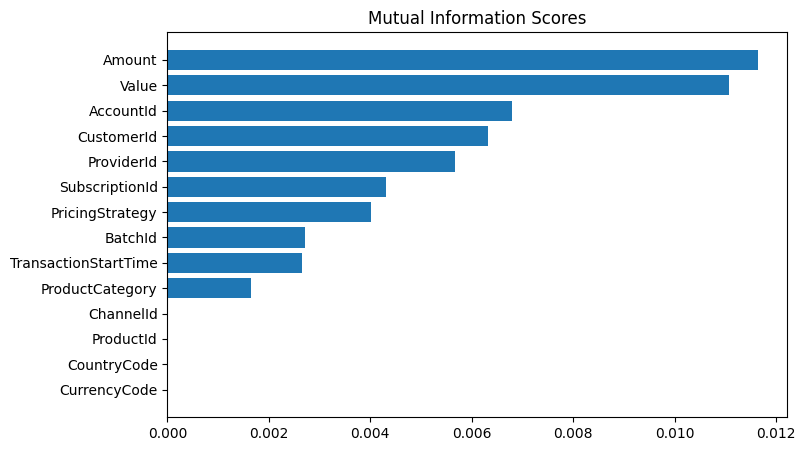

In [5]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

As we can see in the plot, the `BatchId` is the most dominant columns. But we cannot take this one into account as it is a biased value due to the fact the the `BatchId`is only an identification for the transaction.

Same for `CustomerId`, `AccountId` and `SubscriptionId`, because they refers to customers. We do not want to predict a fraud based on the customers habits.

Based on what have been said before, here is the new Mutual Information removing the following columns: `BatchId`, `CustomerId`, `AccountId` and `SubscriptionId`.

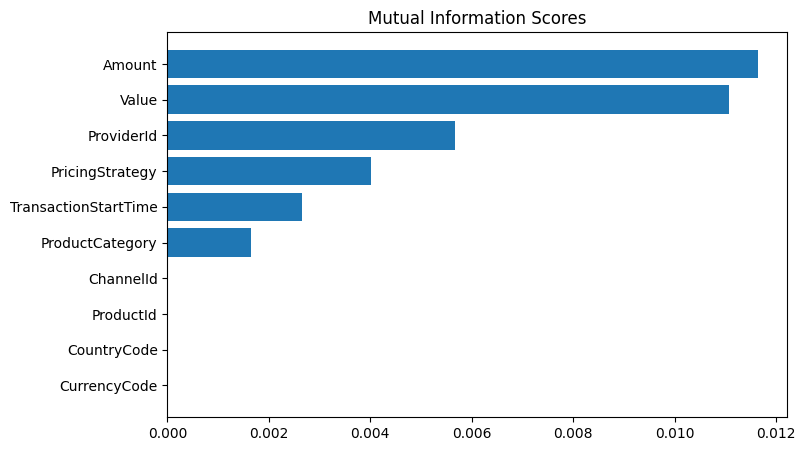

In [6]:
# Define columns to remove
ColsToRemove = ['BatchId', 'CustomerId', 'AccountId', 'SubscriptionId']

# Remove useless columns
mi_scores_copy = mi_scores.drop(ColsToRemove)

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores_copy)

## Transaction country

First, we will attack with the columns `CurrencyCode` and `CountryCode`. Actually, they point to the same thing: from which country the transaction has been done. Thus, we can say that having both columns is redundant to estimate our model prediction.

We will first look at the occurence of every country and then check its relationship with the target value.

In [7]:
# Load CurrencyCode and CountryCode
X_CurrencyCode = training_data['CurrencyCode']
X_CountryCode = training_data['CountryCode']

# Count occurence of each rows
CurrencyCode_Occurences = X_CurrencyCode.value_counts()
CountryCode_Occurences = X_CountryCode.value_counts()

# Show information
print(CurrencyCode_Occurences)
print('\n---\n')
print(CountryCode_Occurences)

CurrencyCode
UGX    95662
Name: count, dtype: int64

---

CountryCode
256    95662
Name: count, dtype: int64


As we can see, `CurrencyCode` and `CountryCode` has only one distinct value in all the dataset. Give that, we can say that this columns will not give any additional information to our model.

Based on the Mutual Information calculated above, we can see than `CurrencyCode` and `CountryCode` are independent variables.

## Transaction Start Time

As information, we have `TransactionStartTime` and it is the transaction start time. It is written using the [ISO 8601](https://en.wikipedia.org/wiki/ISO_8601) date format. In this form, we cannot exploit the data in our model.

From the date, we can take some interesting information such as:
 * Day of the week
 * Month
 * Period of the year

By retrieving this information, we can try to visualise if the fraud is something periodically, that happens on certain week day, ...

Given that, our first step will be to preprocessing our data and create 2 new columns: `TransactionWeekDay` and `TransactionMonth.`

 * **TransactionWeekDay**: 0 - 6
 * **TransactionMonth**: 0 - 11

In [8]:
from datetime import datetime
import re

def date_to_weekday_month(row):
    date, hour, _ = re.split('Z|T', row['TransactionStartTime'].strip())

    # Create datetime object from the ISO date
    row_date = datetime.strptime(date, '%Y-%m-%d')
    
    # Add the week and month into the data
    row['TransactionWeekDay'] = row_date.weekday()
    row['TransactionMonth'] = row_date.month

    return row

In [9]:
def apply_transaction_start_date(destination):
    # Convert every string in datetime object
    pdDatetime = pd.to_datetime(training_data['TransactionStartTime'])
    pdDatetimeIndex = pd.DatetimeIndex(pdDatetime)

    # Retrieve month and week day
    destination['TransactionWeekDay'] = pdDatetimeIndex.weekday
    destination['TransactionMonth'] = pdDatetimeIndex.month

    # Apply the function on every row
    # destination = destination.apply(date_to_weekday_month, axis=1)

    # Drop TransactionStartTime
    destination.drop(columns=['TransactionStartTime'], inplace=True)

    return destination

In [25]:
# Create an empty DataFrame
# TransactionStartTimeDetails = training_data.loc[:, ['TransactionStartTime']].copy()

# # Apply the treatment to TransactionStartTime
# TransactionStartTimeDetails = apply_transaction_start_date(TransactionStartTimeDetails)

# TransactionStartTimeDetails.head()

TransactionStartTimeDetails = training_data.loc[:, ['TransactionStartTime']].copy()

# test['date'], test['hour'], _ = re.split('Z|T', training_data.loc[:, ['TransactionStartTime']].copy())


TransactionStartTimeSplitted = training_data['TransactionStartTime'].str.split(r'Z|T', expand=True)
# RowDate = TransactionStartTimeSplitted[0]datetime.strptime(, '%Y-%m-%d')
test['month'] = pd.DatetimeIndex(pd.to_datetime(training_data['TransactionStartTime'])).month

test.head()

,month
0,11
1,11
2,11
3,11
4,11


### Mutual information for Month and Week day

Now that we have the information about `TransactionWeekDay` and `TransactionMonth`, we can compute their Mutual Information.

In [ ]:
# Define the variable to check the relationship
X = TransactionStartTimeDetails[['TransactionMonth', 'TransactionWeekDay']]
y = training_data['FraudResult']

# Get the discrete features just to be sure
discrete_features = X.dtypes == int

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores

TransactionWeekDay    0.000887
TransactionMonth      0.000000
Name: MI Scores, dtype: float64

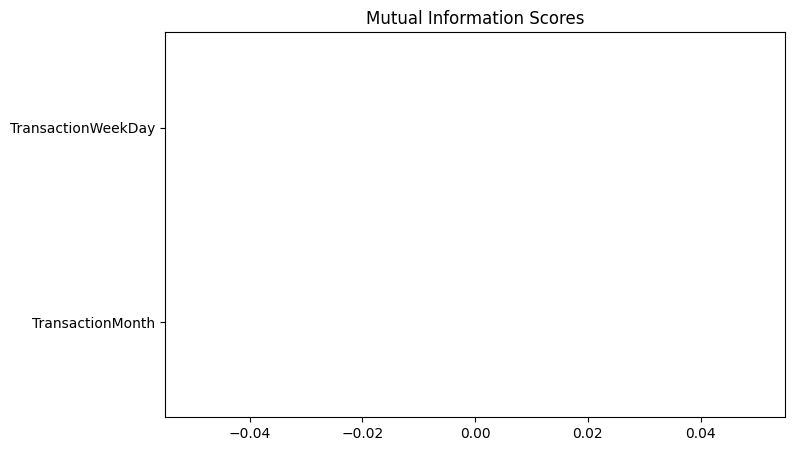

In [ ]:
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

# Fraud frequency per week day

We will know plot the fraud frequency regarding the month.

In [ ]:
# Create DataFram with the month and fraud
FraudMonth = pd.DataFrame({
    'TransactionWeekDay': TransactionStartTimeDetails['TransactionWeekDay'],
    'FraudResult': training_data['FraudResult'],
})

# Group the dataframe by month
FraudPerWeekDay = FraudMonth.groupby('TransactionWeekDay').sum()
FraudPerWeekDay.reset_index(inplace=True)

FraudPerWeekDay.head(10)

,TransactionWeekDay,FraudResult
0,0,29
1,1,31
2,2,29
3,3,34
4,4,30
5,5,25
6,6,15


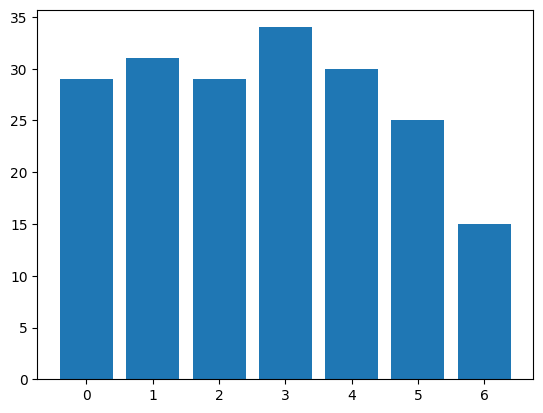

In [ ]:
# Creating histogram
plt.bar(FraudPerWeekDay['TransactionWeekDay'], FraudPerWeekDay['FraudResult'])
 
# Show plot
plt.show()

We see that there is no pattern that appears between the week days. A fraud can happens any day of the week. Given that, I will not use `TransactionWeekDay` in my model.

# Fraud frequency per month

We will know plot the fraud frequency regarding the month.

In [ ]:
# Create DataFram with the month and fraud
FraudMonth = pd.DataFrame({
    'TransactionMonth': TransactionStartTimeDetails['TransactionMonth'],
    'FraudResult': training_data['FraudResult'],
})

# Group the dataframe by month
FraudPerMonth = FraudMonth.groupby('TransactionMonth').sum()
FraudPerMonth.reset_index(inplace=True)

FraudPerMonth.head(10)

,TransactionMonth,FraudResult
0,1,64
1,2,53
2,11,14
3,12,62


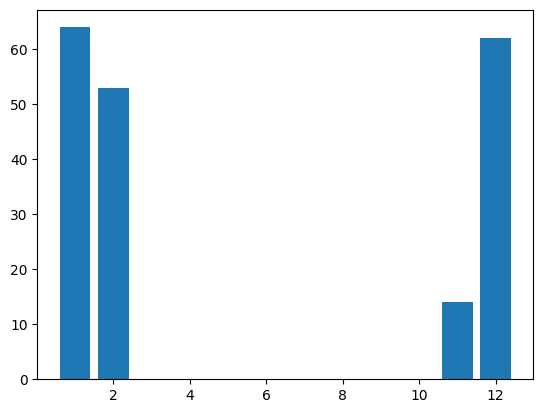

In [ ]:
# Creating bar graph
plt.bar(FraudPerMonth['TransactionMonth'], FraudPerMonth['FraudResult'])
 
# Show plot
plt.show()

As we can see, there is a periodical pattern. The fraud generally happens during the month of november to february.

We can then use this data in our model.

## Result

As we can see in this plot, it is not a periodical pattern and so the month and week day does not give us any additional information.

But for the sake of the analysis, we will keep `TransactionMonth` and `TransactionWeekDay`, because `TransactionStartTime` will be just converted in a categorical variable that will bias our model.

## Way to pay

For the next analysis, we will look at `Amount`. In the variable description, it says that the positive values refers to debit and negative to credit.

Given that information, we can analyse if a debit or credit payment affect the fraud violation.

The first step will be to extract this information, we will then create a column name `PaymentWay`. This column will have `0` if it is a debit and `1` if credit.

 * **PaymentWay**: 0 if debit, 1 if credit

In [ ]:
def get_credit_debit(row):
    row['PaymentWay'] = 'debit' if row['Amount'] > 0 else 'credit'
    return row

In [ ]:
def apply_payment_way(destination):
    # Get the payment information
    destination = destination.apply(get_credit_debit, axis=1)

    # Remove the Amount columns
    destination.drop(columns=['Amount'], inplace=True)

    return destination

In [ ]:
# Create an empty DataFrame
PaymentInformation = training_data.loc[:, ['Amount']].copy()

# Apply the payment way function
PaymentInformation = apply_payment_way(PaymentInformation)

PaymentInformation.head()

,PaymentWay
TransactionId,
TransactionId_76871,debit
TransactionId_73770,credit
TransactionId_26203,debit
TransactionId_380,debit
TransactionId_28195,credit


### Mutual Information for Payment Way

We can now make the Mutual Information between `PaymentWay`and the target value.

In [ ]:
# Define the variable to check the relationship
X = PaymentInformation.copy()
y = training_data['FraudResult']

# Categorise PaymentWay
X['PaymentWay'], _ = X['PaymentWay'].factorize()

# Get the discrete features just to be sure
discrete_features = X.dtypes == int

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores

PaymentWay    0.001557
Name: MI Scores, dtype: float64

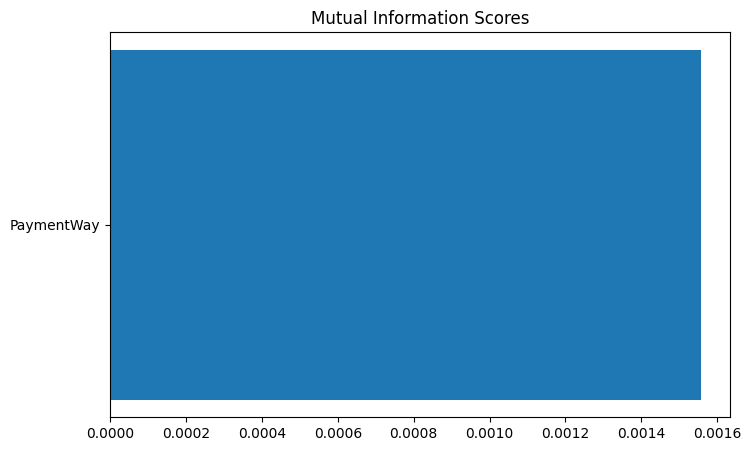

In [ ]:
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

As we can see, the payment way does not affect the fraud violation.

### Fraud frequency per Payment Way

We will analyse the fraud frequency regarding the payment method used: Debit or Credit.

In [ ]:
# Create DataFram with the month and fraud
FraudPaymentWay = pd.DataFrame({
    'PaymentWay': PaymentInformation['PaymentWay'],
    'FraudResult': training_data['FraudResult'],
})


# Group the dataframe by month
FraudPerPaymentWay = FraudPaymentWay.groupby('PaymentWay').sum()
FraudPerPaymentWay.reset_index(inplace=True)

FraudPerPaymentWay.head(10)

,PaymentWay,FraudResult
0,credit,5
1,debit,188


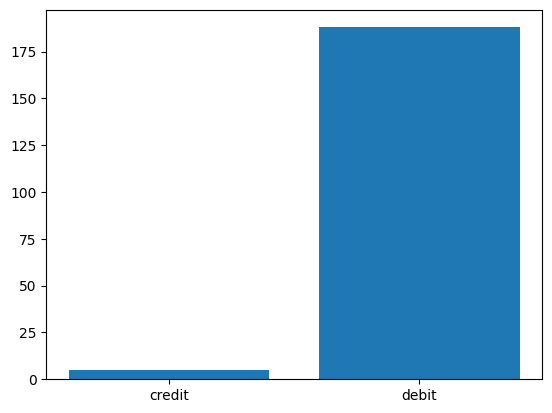

In [ ]:
# Creating bar graph
plt.bar(FraudPerPaymentWay['PaymentWay'], FraudPerPaymentWay['FraudResult'])
 
# Show plot
plt.show()

## Pricing strategy

We are going to analyse the pricing strategy and check its influence on the fraud detection.

In [ ]:
# Retrieve the pricing strategy
PricingStrategy = training_data.loc[:, ['PricingStrategy', 'FraudResult']]

# Check the number of fraud per princing strategy
FraudPerPricingStrategy = PricingStrategy.groupby('PricingStrategy').sum()
FraudPerPricingStrategy.reset_index(inplace=True)

FraudPerPricingStrategy.head()

,PricingStrategy,FraudResult
0,0,36
1,1,7
2,2,139
3,4,11


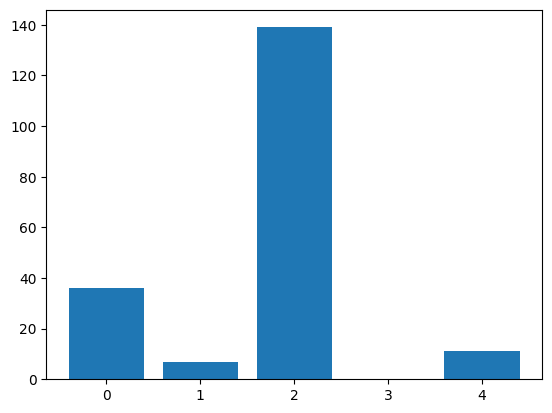

In [ ]:
# Creating bar graph
plt.bar(FraudPerPricingStrategy['PricingStrategy'], FraudPerPricingStrategy['FraudResult'])
 
# Show plot
plt.show()

## Channel ID

In [ ]:
# Retrieve the pricing strategy
ChannelId = training_data.loc[:, ['ChannelId', 'FraudResult']]

# Check the number of fraud per princing strategy
FraudPerChannelId = ChannelId.groupby('ChannelId').sum()
FraudPerChannelId.reset_index(inplace=True)

FraudPerChannelId.head()

,ChannelId,FraudResult
0,ChannelId_1,4
1,ChannelId_2,5
2,ChannelId_3,184
3,ChannelId_5,0


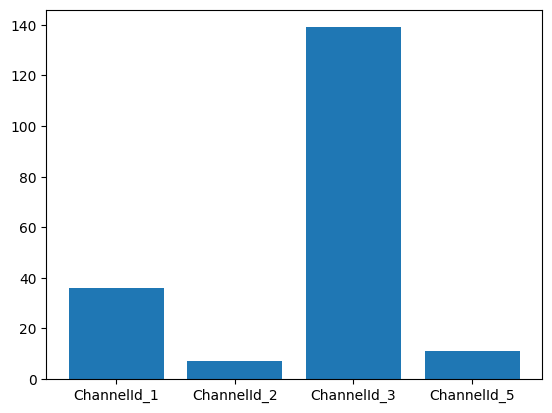

In [ ]:
# Creating bar graph
plt.bar(FraudPerChannelId['ChannelId'], FraudPerPricingStrategy['FraudResult'])
 
# Show plot
plt.show()

## Conclusion

At the end of our journey, blah blah blah...

## Categorise the data

Now we are going the categorise our discrete value. We will apply a One-Hot Encoder on `ProductCategory` and `ChannelId`.

As a reminder, a One-Hot Encoder will create new binary columns, indicating the presence of each possible values from the original data.

![One-Hot Encoding](./pictures/one-hot-encoding.png)

One-Hot Encoding works well when the categorical variable takes on a small number of values (15 regarding [Kaggle](https://www.kaggle.com/code/dansbecker/using-categorical-data-with-one-hot-encoding)).

We will then check the number of unique categories in every one of our columns, and apply One-Hot Encoding if the distinct values is less than `15`.


In [ ]:
# Define the columns to categorise
CategoriseCols = ['ProductCategory']

# Extract our categorical variable
CategoricalVariable = training_data.loc[:, CategoriseCols]

# Get number of unique values in each column
CategoricalVariable.nunique()

ProductCategory    9
ChannelId          4
dtype: int64

As we can see, `ProductCategory` has 9 distincts values and `ChannelId`has 4. We can then apply One-Hot Encoding on each column.

In [344]:
from sklearn.preprocessing import OneHotEncoder

# Define the columns to categorise
CategoriseCols = ['ProductCategory', 'ChannelId']

# Define One-Hot Encoder
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Apply encoder to the ProductCategory column
# OH_cols_train = OH_encoder.fit_transform(training_data[CategoriseCols])

# OH_cols_train.head()
pd.get_dummies(data=X_train, columns=CategoriseCols)

#training_data.head()

AttributeError: 'numpy.ndarray' object has no attribute 'head'

# Set our data for the model

Here we are going to set the data that we will use to create our model.

In [349]:
# COLS_TO_USE = ['ProductCategory', 'ChannelId', 'Amount', 'TransactionStartTime', 'PricingStrategy']
COLS_TO_USE = ['Amount', 'TransactionStartTime', 'ProductCategory', 'Value', 'PricingStrategy']

def prepare_dataset(data_source):
    dataset = data_source[COLS_TO_USE].copy()

    dataset = apply_payment_way(dataset)
    dataset = apply_transaction_start_date(dataset)

    return dataset

In [355]:
from sklearn.model_selection import train_test_split
CategoriseCols = ['ProductCategory', 'PaymentWay']

# Check my dataset
# training_data.reset_index(inplace=True)
X = prepare_dataset(training_data)
y = training_data['FraudResult']

X = pd.get_dummies(data=X, columns=CategoriseCols)

# Stratified
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0, stratify=y)


# Define the columns to categorise


# Define One-Hot Encoder
# OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
# 
# Apply encoder to the ProductCategory column
# OH_cols_train = OH_encoder.fit_transform(training_data[CategoriseCols])



In [356]:

# OH_cols_train.head()
# X_train = pd.get_dummies(data=X_train, columns=CategoriseCols)
# X_test = pd.get_dummies(data=X_test, columns=CategoriseCols)

X_train.head()

,Value,PricingStrategy,TransactionWeekDay,TransactionMonth,ProductCategory_airtime,ProductCategory_data_bundles,ProductCategory_financial_services,ProductCategory_movies,ProductCategory_other,ProductCategory_ticket,ProductCategory_transport,ProductCategory_tv,ProductCategory_utility_bill,PaymentWay_credit,PaymentWay_debit
67346,50,2,0,1,False,False,True,False,False,False,False,False,False,True,False
37588,20000,2,5,12,False,False,True,False,False,False,False,False,False,False,True
87804,392,2,3,2,False,False,True,False,False,False,False,False,False,True,False
48482,500,4,1,1,False,True,False,False,False,False,False,False,False,False,True
85364,50,2,0,2,False,False,True,False,False,False,False,False,False,True,False


**TODO**

A this time we have
 * Column 1
 * COlumn 2
 * ...

# Unbalanced dataset

Before explaining what is a unbalanced datasets, I will show you the proportion between the non-fraud and fraud rows of the dataset.

In [ ]:
y = training_data['FraudResult']

# Compute the percentage value of fraud
fraud_percentage = y.sum() / len(y)

print(f'{fraud_percentage * 100.0}% of fraud.')

0.20175200183981098% of fraud.


In [ ]:
# Explain over sampling

# Create the model

**TODO**

For that we use a pipeline to automatically ...

## Preprocessing step

**TODO**

One Hot encoder

In [337]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


# Define the categorical columns
# CATEGORICAL_COLS = ['ProductCategory', 'ChannelId', 'PricingStrategy', 'PaymentWay',]
CATEGORICAL_COLS = ['ProductCategory', 'PaymentWay',]

# Define preprocessor
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('one-hot', OneHotEncoder(handle_unknown='ignore',), CATEGORICAL_COLS),
#     ]
# )

# Define One-Hot Encoder
OH_encoder = OneHotEncoder(handle_unknown='ignore')

# Apply encoder to the ProductCategory column
# OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[CATEGORICAL_COLS]))
OH_cols_train = OH_encoder.fit_transform(X_train[CATEGORICAL_COLS])
print(OH_cols_train)


  (0, 2)	1.0
  (0, 9)	1.0
  (1, 2)	1.0
  (1, 10)	1.0
  (2, 2)	1.0
  (2, 9)	1.0
  (3, 1)	1.0
  (3, 10)	1.0
  (4, 2)	1.0
  (4, 9)	1.0
  (5, 2)	1.0
  (5, 10)	1.0
  (6, 0)	1.0
  (6, 10)	1.0
  (7, 0)	1.0
  (7, 10)	1.0
  (8, 0)	1.0
  (8, 10)	1.0
  (9, 2)	1.0
  (9, 9)	1.0
  (10, 2)	1.0
  (10, 9)	1.0
  (11, 2)	1.0
  (11, 9)	1.0
  (12, 0)	1.0
  :	:
  (76516, 9)	1.0
  (76517, 0)	1.0
  (76517, 9)	1.0
  (76518, 2)	1.0
  (76518, 9)	1.0
  (76519, 0)	1.0
  (76519, 10)	1.0
  (76520, 0)	1.0
  (76520, 10)	1.0
  (76521, 7)	1.0
  (76521, 10)	1.0
  (76522, 0)	1.0
  (76522, 10)	1.0
  (76523, 0)	1.0
  (76523, 10)	1.0
  (76524, 0)	1.0
  (76524, 10)	1.0
  (76525, 0)	1.0
  (76525, 10)	1.0
  (76526, 2)	1.0
  (76526, 9)	1.0
  (76527, 0)	1.0
  (76527, 10)	1.0
  (76528, 2)	1.0
  (76528, 9)	1.0


In [247]:
# preprocessor.fit_transform(X)

ValueError: A given column is not a column of the dataframe

# Model

**TODO**

Define the model

In [360]:
from sklearn.ensemble import RandomForestClassifier

# Decision tree as first model
model = RandomForestClassifier(n_estimators=300, max_depth=15, random_state = 0)

## Pipeline

**TODO**

Define the pipeline

In [329]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
    # ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=0)),
    # ('scale', StandardScaler(with_mean=False)),
    ('model', model),
])

In [358]:
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, n_estimators=300, random_state=0)

In [331]:
from sklearn.model_selection import cross_val_score

# cross_val_score(pipeline, X, y, cv=5)

In [359]:
from sklearn.metrics import f1_score

preds = model.predict(X_test)

print(f1_score(y_test, preds))

0.7945205479452054


# Predictions

**TODO**

We will make the prediction with our model

In [286]:
# Path to the test data
test_data_path = './data/test.csv'

# Load test data
test_data = pd.read_csv(test_data_path)

# Get the target
X_valid = prepare_dataset(test_data.copy())

X_valid.head()

,ProductCategory,PricingStrategy,PaymentWay,TransactionWeekDay,TransactionMonth
0,airtime,4,debit,2,2
1,financial_services,2,debit,2,2
2,financial_services,2,credit,2,2
3,airtime,4,debit,2,2
4,financial_services,2,credit,2,2


In [287]:
from sklearn.metrics import mean_absolute_error

pred = pd.Series(
    pipeline.predict(X_valid)
)

pred.head()


0    0
1    1
2    0
3    0
4    0
dtype: int64

In [288]:
sample_submission_path = './data/sample_submission.csv'

sample_submission =  pd.read_csv(sample_submission_path)

sample_submission['FraudResult'] = pred

sample_submission.to_csv('./data/my_submission.csv', index=False)